In [1]:
import pandas as pd
import numpy as np
import hashlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from itertools import compress
from sklearn.externals import joblib
import datetime

Importing data with pandas

In [3]:
df_seed = pd.read_csv(r'F:\CODE\NCAA 2018\Stage2UpdatedDataFiles\NCAATourneySeeds.csv')
df_tourney_compact = pd.read_csv(r'F:\CODE\NCAA 2018\DataFiles\NCAATourneyCompactResults.csv')
df_tourney_detail = pd.read_csv(r'F:\CODE\NCAA 2018\DataFiles\NCAATourneyDetailedResults.csv')
df_reg_compact = pd.read_csv(r'F:\CODE\NCAA 2018\DataFiles\RegularSeasonCompactResults.csv')
df_reg_detail = pd.read_csv(r'F:\CODE\NCAA 2018\Stage2UpdatedDataFiles\RegularSeasonDetailedResults.csv')
df_Ordinal = pd.read_csv(r'F:\CODE\NCAA 2018\MasseyOrdinals\MasseyOrdinals_thruSeason2018_Day128.csv')
df_rating = df_Ordinal[df_Ordinal['SystemName'].str.contains('WOL')]
syslist = list(df_Ordinal['SystemName'].unique())
df_seed['seed rank'] = df_seed['Seed'].apply(lambda x: int(x[1:3]))
df_seed = df_seed[df_seed['Season'] >= 2003].drop('Seed', axis = 1)
df_reg_compact = df_reg_compact[df_reg_compact['Season'] >= 2003]
df_tourney_compact = df_tourney_compact.drop(['DayNum', 'WLoc', 'NumOT'], axis = 1)
df_tourney_detail = df_tourney_detail.drop(['DayNum', 'WLoc', 'NumOT'], axis = 1)
df_reg_compact = df_reg_compact.drop(['DayNum', 'WLoc', 'NumOT'], axis = 1)
df_reg_detail = df_reg_detail.drop(['DayNum', 'WLoc', 'NumOT'], axis = 1)

df_regular = df_reg_detail.merge(df_seed, left_on = ['WTeamID', 'Season'], right_on = ['TeamID', 'Season'], how = 'outer').drop('TeamID', axis = 1)
df_regular = df_regular.rename(index = str, columns = {'seed rank': 'WSeed'})
df_regular = df_regular.merge(df_seed, left_on = ['LTeamID', 'Season'], right_on = ['TeamID', 'Season'], how = 'outer').drop('TeamID', axis = 1)
df_regular = df_regular.rename(index = str, columns = {'seed rank': 'LSeed'})
fillna = {'WSeed': 17, 'LSeed': 17}
df_regular = df_regular.fillna(value = fillna)
df_regular = df_regular.dropna(how = 'any')
print('The total number of regular season instance is {}.'.format(len(df_regular.index)))
df_regular = df_regular.drop(['WScore', 'LScore'], axis = 1)

df_tourney = df_tourney_detail.merge(df_seed, left_on = ['WTeamID', 'Season'], right_on = ['TeamID', 'Season'], how = 'outer').drop('TeamID', axis = 1)
df_tourney = df_tourney.rename(index = str, columns = {'seed rank': 'WSeed'})
df_tourney = df_tourney.merge(df_seed, left_on = ['LTeamID', 'Season'], right_on = ['TeamID', 'Season'], how = 'outer').drop('TeamID', axis = 1)
df_tourney = df_tourney.rename(index = str, columns = {'seed rank': 'LSeed'})
df_tourney = df_tourney.dropna(how = 'any')
print('The total number of tourney instance is {}.'.format(len(df_tourney.index)))
df_tourney = df_tourney.drop(['WScore', 'LScore'], axis = 1)

The total number of regular season instance is 82041.
The total number of tourney instance is 981.


Calculate advanced stats for each game.

In [4]:
df_total = pd.concat((df_regular, df_tourney), axis = 0)
Attributes = list(df_total.drop(['Season', 'WTeamID', 'LTeamID', 'WSeed', 'LSeed'], axis = 1).columns.values)
# Win/lose points
df_total['WPts'] = df_total.apply(lambda row: 2*row.WFGM + row.WFGM3 + row.WFTM, axis=1)
df_total['LPts'] = df_total.apply(lambda row: 2*row.LFGM + row.LFGM3 + row.LFTM, axis=1)
#Win/lose possession
wPos = df_total.apply(lambda row: 0.96*(row.WFGA + row.WTO + 0.44*row.WFTA - row.WOR), axis=1)
lPos = df_total.apply(lambda row: 0.96*(row.LFGA + row.LTO + 0.44*row.LFTA - row.LOR), axis=1)
#Average possession per game
df_total['Pos'] = (wPos+lPos)/2
#Offensive efficiency
df_total['WOffRtg'] = df_total.apply(lambda row: 100 * (row.WPts / row.Pos), axis=1)
df_total['LOffRtg'] = df_total.apply(lambda row: 100 * (row.LPts / row.Pos), axis=1)
#Defensive efficiency
df_total['WDefRtg'] = df_total.LOffRtg
df_total['LDefRtg'] = df_total.WOffRtg
#Net Rating
df_total['WNetRtg'] = df_total.apply(lambda row:(row.WOffRtg - row.WDefRtg), axis=1)
df_total['LNetRtg'] = df_total.apply(lambda row:(row.LOffRtg - row.LDefRtg), axis=1)
#Assist Ratio
df_total['WAstR'] = df_total.apply(lambda row: 100 * row.WAst / (row.WFGA + 0.44*row.WFTA + row.WAst + row.WTO), axis=1)
df_total['LAstR'] = df_total.apply(lambda row: 100 * row.LAst / (row.LFGA + 0.44*row.LFTA + row.LAst + row.LTO), axis=1)
# Turnover Ratio
df_total['WTOR'] = df_total.apply(lambda row: 100 * row.WTO / (row.WFGA + 0.44*row.WFTA + row.WAst + row.WTO), axis=1)
df_total['LTOR'] = df_total.apply(lambda row: 100 * row.LTO / (row.LFGA + 0.44*row.LFTA + row.LAst + row.LTO), axis=1)
#Shooting Percentage
df_total['WTSP'] = df_total.apply(lambda row: 100 * row.WPts / (2 * (row.WFGA + 0.44 * row.WFTA)), axis=1)
df_total['LTSP'] = df_total.apply(lambda row: 100 * row.LPts / (2 * (row.LFGA + 0.44 * row.LFTA)), axis=1)
#Effective field goal
df_total['WeFGP'] = df_total.apply(lambda row:(row.WFGM + 0.5 * row.WFGM3) / row.WFGA, axis=1)      
df_total['LeFGP'] = df_total.apply(lambda row:(row.LFGM + 0.5 * row.LFGM3) / row.LFGA, axis=1)
# FTA Rate
df_total['WFTAR'] = df_total.apply(lambda row: row.WFTA / row.WFGA, axis=1)
df_total['LFTAR'] = df_total.apply(lambda row: row.LFTA / row.LFGA, axis=1)
# OREB%
df_total['WORP'] = df_total.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
df_total['LORP'] = df_total.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)
# DREB%
df_total['WDRP'] = df_total.apply(lambda row: row.WDR / (row.WDR + row.LOR), axis=1)
df_total['LDRP'] = df_total.apply(lambda row: row.LDR / (row.LDR + row.WOR), axis=1)
#REB%
df_total['WRP'] = df_total.apply(lambda row: (row.WDR + row.WOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1)
df_total['LRP'] = df_total.apply(lambda row: (row.LDR + row.WOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1) 
Attributes.append('Pos')
df_total = df_total.drop(columns = Attributes)
df_total = df_total.reset_index()
df_total = df_total.drop('index', axis = 1)

winnerStats = list(compress(df_total.drop(['Season', 'WTeamID', 'LTeamID', 'WSeed'], axis = 1).columns.values, [x.startswith('W') for x in df_total.drop(['Season', 'WTeamID', 'LTeamID', 'WSeed'], axis = 1).columns.values]))
loserStats = list(compress(df_total.drop(['Season', 'WTeamID', 'LTeamID', 'LSeed'], axis = 1).columns.values, [x.startswith('L') for x in df_total.drop(['Season', 'WTeamID', 'LTeamID', 'LSeed'], axis = 1).columns.values]))

df_dummy = df_total[:-981]

for year in df_total['Season'].unique():
    df_dummy_1 = df_dummy[df_dummy['Season'] == year]
    for team in pd.concat((df_dummy_1['WTeamID'], df_dummy_1['LTeamID'])).unique():
        df_dummy_2 = df_dummy_1[(df_dummy_1['WTeamID'] == team)]
        df_dummy_2_mean = df_dummy_2[winnerStats].mean().values
        df_dummy_3 = df_dummy_1[(df_dummy_1['LTeamID'] == team)]
        df_dummy_3_mean = df_dummy_3[loserStats].mean().values
        if len(df_dummy_2.index) == 0:
            TotalMean = df_dummy_3_mean
        elif len(df_dummy_3.index) == 0:
            TotalMean = df_dummy_2_mean
        else:
            TotalMean = (df_dummy_2_mean + df_dummy_3_mean) / 2
        
        index_W = df_total[(df_total['WTeamID'] == team) & (df_total['Season'] == year)].index
        df_total.loc[index_W, winnerStats] = TotalMean
        index_L = df_total[(df_total['LTeamID'] == team) & (df_total['Season'] == year)].index
        df_total.loc[index_L, loserStats] = TotalMean

for year in df_total['Season'].unique():
    dummy = df_rating[df_rating['Season'] == year]
    for team in dummy['TeamID'].unique():
        dummy2 = dummy[(dummy['TeamID'] == team)]
        OR = dummy2['OrdinalRank'].to_frame().values[-1]
        index1 = df_total[(df_total['WTeamID'] == team) & (df_total['Season'] == year)].index
        index2 = df_total[(df_total['LTeamID'] == team) & (df_total['Season'] == year)].index
        if len(index1) != 0:
            df_total.loc[index1, 'WOR'] = OR
        if len(index2) != 0:
            df_total.loc[index2, 'LOR'] = OR

df_total = df_total.dropna(how = 'any')
df_total.to_pickle('./df_total.pkl')

Prepare training, validation and test data.

In [5]:
winnerStats = list(compress(df_total.drop(['Season', 'WTeamID', 'LTeamID'], axis = 1).columns.values, [x.startswith('W') for x in df_total.drop(['Season', 'WTeamID', 'LTeamID'], axis = 1).columns.values]))
loserStats = list(compress(df_total.drop(['Season', 'WTeamID', 'LTeamID'], axis = 1).columns.values, [x.startswith('L') for x in df_total.drop(['Season', 'WTeamID', 'LTeamID'], axis = 1).columns.values]))
test_split = df_total[-981:].copy()
test_index = test_split[test_split['Season'] >= 2017].index[0]

df_winner = df_total[winnerStats].copy()
df_loser = df_total[loserStats].copy()
df_win = pd.concat([df_total[['Season', 'WTeamID', 'LTeamID']], df_winner, df_loser], axis = 1)
df_lose = pd.concat([df_total[['Season', 'WTeamID', 'LTeamID']], df_loser, df_winner], axis = 1)
df_win['label'] = 1
df_lose['label'] = 0
renamedict = dict(zip(loserStats+winnerStats, winnerStats+loserStats))
df_lose = df_lose.rename(index = str, columns = renamedict).reset_index(drop = True)

df_target = pd.concat([df_win.loc[test_index:], df_lose.loc[test_index:]])
droplist = ['Season', 'WTeamID', 'LTeamID', 'label']
df_data = pd.concat((df_win, df_lose))
df_data_x = df_data.drop(droplist, axis = 1)
df_data_y = df_data['label']
X_train, X_test, y_train, y_test = train_test_split(df_data_x, df_data_y, test_size = 0.1)
_, X_val, _, y_val = train_test_split(X_train, y_train, test_size = 0.2)

X_target = df_target.drop(droplist, axis = 1)
y_target = df_target['label']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_val_scaled = scaler.fit_transform(X_val)
X_target_scaled = scaler.fit_transform(X_target)
print('Number of feature = {}'.format(len(X_train.columns.values)))
print('Number of training instance = {}'.format(len(df_data.index)))
print('Number of CV instance = {}'.format(len(X_val.index)))
print('Number of test instance = {}'.format(len(X_test.index)))
print('Number of target instance = {}'.format(len(X_target.index)))

Number of feature = 28
Number of training instance = 166024
Number of CV instance = 29885
Number of test instance = 16603
Number of target instance = 124


Simple baseline estimator with logistic regression.

In [6]:
lrclf = LogisticRegression()
params_dict = {'C': np.logspace(start=-5,stop=3,num=5)}
grid_search = GridSearchCV(lrclf, params_dict, scoring = 'neg_log_loss',
              cv = 3, refit = True)
grid_search.fit(X_train_scaled, y_train)
print('Best score is: {}.\nBest parameter is: {}'.format(grid_search.best_score_,grid_search.best_params_))
y_pred_test = grid_search.predict_proba(X_test_scaled)[:,1]
print('Test Log loss is {}'.format(log_loss(y_test.values.reshape(-1,1), y_pred_test.reshape(-1,1))))
y_pred_CV = grid_search.predict_proba(X_val_scaled)[:,1]
print('CV loss is {}'.format(log_loss(y_val.values.reshape(-1,1), y_pred_CV.reshape(-1,1))))
y_pred_target = grid_search.predict_proba(X_target_scaled)[:,1]
print('Target loss is {}'.format(log_loss(y_target.values.reshape(-1,1), y_pred_target.reshape(-1,1))))

Best score is: -0.48694866110522406.
Best parameter is: {'C': 0.10000000000000001}
Test Log loss is 0.4869121827651006
CV loss is 0.48540220679931967
Target loss is 0.5331412789955903


Trying to get better results using a simple fully connected network.<br>
I added dropout to suppress overfitting. I have tried dropout range 0.2~0.9 but I found that a slight dropout (0.9) works better in this case.

In [8]:
config = tf.ConfigProto(allow_soft_placement = True)
config.gpu_options.allow_growth = True
n_inputs = 28
n_hidden1 = 28
n_hidden2 = 28
n_hidden3 = 28
n_output = 1
X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = 'X')
y = tf.placeholder(tf.float32, shape = (None, n_output), name = 'y')
hidden1 = fully_connected(X, n_hidden1)
BN_1 = tf.contrib.layers.batch_norm(hidden1, scale = True)
dropout_1 = tf.nn.dropout(BN_1, keep_prob = 0.9)
hidden2 = fully_connected(dropout_1, n_hidden2)
hidden3 = fully_connected(hidden2, n_hidden3)
logits = fully_connected(hidden3, n_output, activation_fn = tf.nn.sigmoid)
xentropy = tf.losses.log_loss(labels = y, predictions = logits)
loss = tf.reduce_mean(xentropy, name = 'loss')
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver(max_to_keep = 999)
n_epochs = 1000
error = []
with tf.Session(config = config) as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        sess.run(training_op, feed_dict = {X: X_train_scaled, y: y_train.values.reshape(-1,1)})
        if epoch % 50 == 0:
            log_loss_train = loss.eval(feed_dict = {X: X_train_scaled, y: y_train.values.reshape(-1,1)})
            log_loss_test = loss.eval(feed_dict = {X: X_test_scaled, y: y_test.values.reshape(-1,1)})
            log_loss_CV = loss.eval(feed_dict = {X: X_val_scaled, y: y_val.values.reshape(-1,1)})
            log_loss_target = loss.eval(feed_dict = {X: X_target_scaled, y: y_target.values.reshape(-1,1)})
            print('Current epoch {} train loss:  {}'.format(epoch, log_loss_train))
            print('Current epoch {} test loss:   {}'.format(epoch, log_loss_test))
            print('Current epoch {} CV loss:     {}'.format(epoch, log_loss_CV))
            print('Current epoch {} target loss: {}'.format(epoch, log_loss_target))
            error.append([epoch, log_loss_train, log_loss_test, log_loss_CV, log_loss_target])
            save_path = saver.save(sess, './BasicNN/3L_NN_Model_{}.ckpt'.format(epoch))

Current epoch 0 train loss:  0.7490081787109375
Current epoch 0 test loss:   0.7459973096847534
Current epoch 0 CV loss:     0.7483544945716858
Current epoch 0 target loss: 0.7642732858657837
Current epoch 50 train loss:  0.5640243291854858
Current epoch 50 test loss:   0.5641112923622131
Current epoch 50 CV loss:     0.5666115283966064
Current epoch 50 target loss: 0.5841959714889526
Current epoch 100 train loss:  0.5159159898757935
Current epoch 100 test loss:   0.5169592499732971
Current epoch 100 CV loss:     0.5140306353569031
Current epoch 100 target loss: 0.5515422224998474
Current epoch 150 train loss:  0.5008491277694702
Current epoch 150 test loss:   0.5047860145568848
Current epoch 150 CV loss:     0.5003970861434937
Current epoch 150 target loss: 0.5457720160484314
Current epoch 200 train loss:  0.4950259029865265
Current epoch 200 test loss:   0.49710455536842346
Current epoch 200 CV loss:     0.4942770004272461
Current epoch 200 target loss: 0.5554591417312622
Current epo

Plotting the model loss curve. It seems like the best model is at around 300~500 iterations.

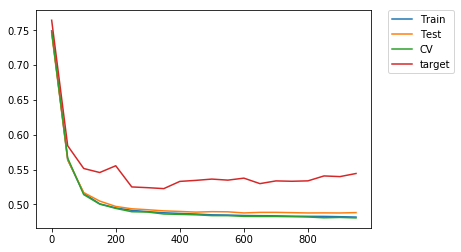

In [9]:
error = np.array(error)
plt.plot(error[:,0], error[:,1], label = 'Train')
plt.plot(error[:,0], error[:,2], label = 'Test')
plt.plot(error[:,0], error[:,3], label = 'CV')
plt.plot(error[:,0], error[:,4], label = 'target')
plt.legend('Train')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

The following code prepare data for the submission set for prediction.

In [10]:
df_fillsubmit = df_total
df_submit = pd.read_csv(r'F:\CODE\NCAA 2018\SampleSubmissionStage2.csv')
df_submit['Season'] = df_submit['ID'].apply(lambda x: int(x[:4]))
df_submit['lowerTeam'] = df_submit['ID'].apply(lambda x: int(x[5:9]))
df_submit['higherTeam'] = df_submit['ID'].apply(lambda x: int(x[10:]))
df_submit = pd.concat((df_submit, pd.DataFrame(columns = winnerStats + loserStats)), axis = 1)

for year in df_submit['Season'].unique():
    dummy = df_submit[df_submit['Season'] == year]
    for team in dummy['lowerTeam'].unique():
        dummy1 = df_fillsubmit[((df_fillsubmit['WTeamID'] == team) | (df_fillsubmit['LTeamID'] == team)) & (df_fillsubmit['Season'] == year)]
        index = dummy1.index.values[0]
        if dummy1.loc[index, 'WTeamID'] == team:
            lower = dummy1.loc[index, winnerStats].values
        else:
            lower = dummy1.loc[index, loserStats].values
        index = df_submit[(df_submit['Season'] == year) & (df_submit['lowerTeam'] == team)].index
        df_submit.loc[index, winnerStats] = lower

for year in df_submit['Season'].unique():
    dummy = df_submit[df_submit['Season'] == year]
    for team in dummy['higherTeam'].unique():
        dummy1 = df_fillsubmit[((df_fillsubmit['WTeamID'] == team) | (df_fillsubmit['LTeamID'] == team)) & (df_fillsubmit['Season'] == year)]
        index = dummy1.index.values[0]
        if dummy1.loc[index, 'WTeamID'] == team:
            higher = dummy1.loc[index, winnerStats].values
        else:
            higher = dummy1.loc[index, loserStats].values
        index = df_submit[(df_submit['Season'] == year) & (df_submit['higherTeam'] == team)].index
        df_submit.loc[index, loserStats] = higher

df_submit = df_submit.drop(['Season', 'lowerTeam', 'higherTeam'], axis = 1)

reorder = X_train.columns.values
dummy = df_submit[reorder]
dummy.head()
df_submit = pd.concat((df_submit.drop(reorder, axis = 1), dummy), axis = 1)

Prediction with logistic regression model.

In [11]:
now = datetime.datetime.now()
CurrentTime = str(now.month) + str(now.day) + str(now.hour) + str(now.minute)
submissionlrclf = np.clip(grid_search.predict_proba(df_submit[reorder])[:,1], 0.05, 0.95)
df_submitform = pd.read_csv(r'F:\CODE\NCAA 2018\SampleSubmissionStage2.csv')
df_submitform['Pred'] = submissionlrclf
df_submitform.to_csv('Logistic Regression Model Submission_{}.csv'.format(CurrentTime), index = False)

Prediction with neural network.

In [12]:
with tf.Session(config = config) as sess:
    saver.restore(sess, './BasicNN/3L_NN_Model_500.ckpt')
    df_submit_scaled = scaler.fit_transform(df_submit[reorder])
    submissionNN = logits.eval(feed_dict = {X: df_submit_scaled})

now = datetime.datetime.now()
CurrentTime = str(now.month) + str(now.day) + str(now.hour) + str(now.minute)
df_submitform = pd.read_csv(r'F:\CODE\NCAA 2018\SampleSubmissionStage2.csv')
df_submitform['Pred'] = submissionNN
df_submitform.to_csv('NN_{} Model Submission.csv'.format(CurrentTime), index = False)

INFO:tensorflow:Restoring parameters from ./BasicNN/3L_NN_Model_500.ckpt
